In [46]:
import sys
import time
import datetime
from qudi.util.network import netobtain
import matplotlib.pyplot as plt
import importlib
sys.path.append('../xq1i')
import libxq1i
importlib.reload(libxq1i)

confocal2 = libxq1i.xq1i(pulsed_master_logic, pulsed_measurement_logic, sequence_generator_logic)

go to POI POI_11 ...
... position and counts at peak after refocus: (53.783, 47.414, 5.785) µm,  σ= (0.159, 0.198, 0.556) µm, peak cnts: 8.52E+04
start measurements for orientation 1 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

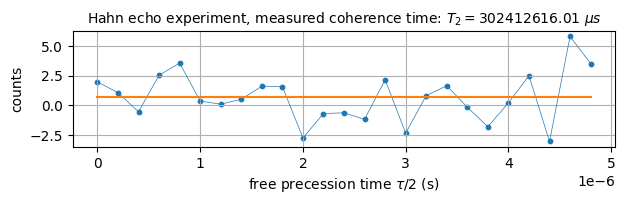

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

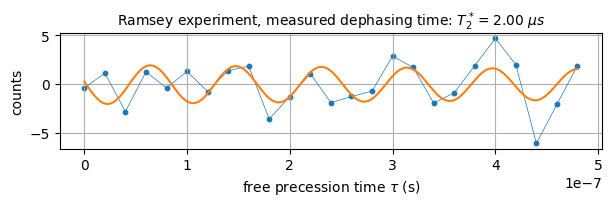

start measurements for orientation 2 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

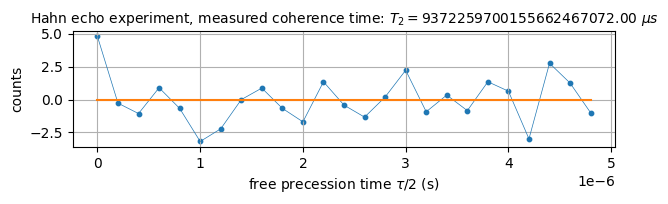

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

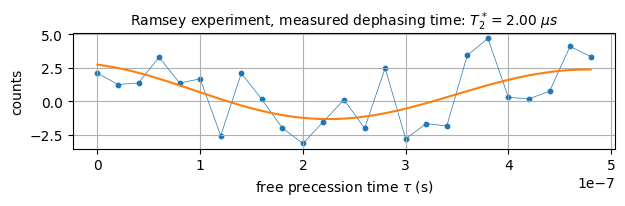

start measurements for orientation 3 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

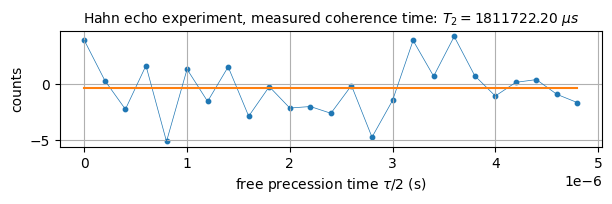

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

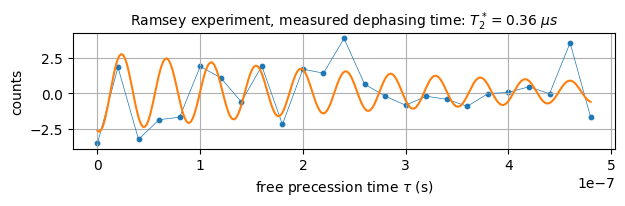

start measurements for orientation 4 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

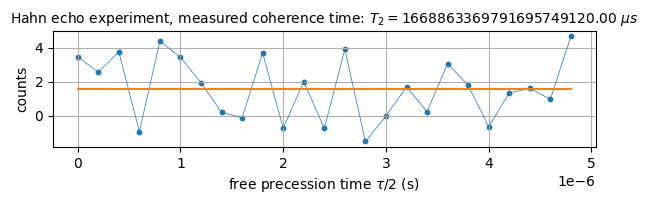

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

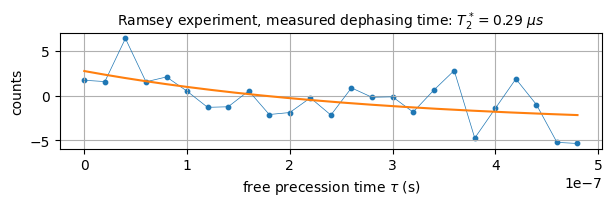

go to POI POI_12 ...
... position and counts at peak after refocus: (53.341, 44.115, 5.873) µm,  σ= (0.173, 0.188, 0.611) µm, peak cnts: 4.96E+04
start measurements for orientation 1 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

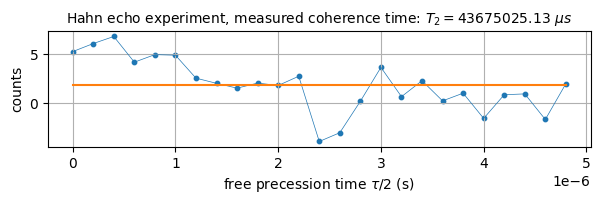

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

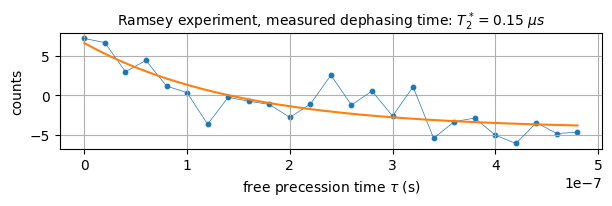

start measurements for orientation 2 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

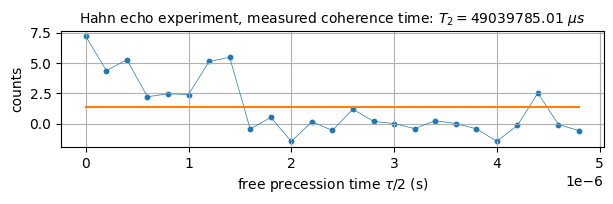

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

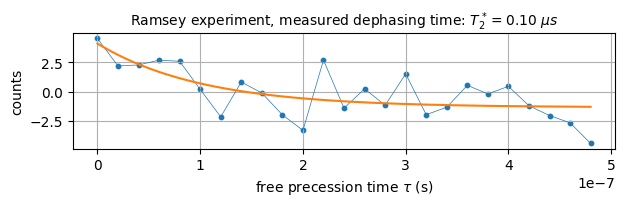

start measurements for orientation 3 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

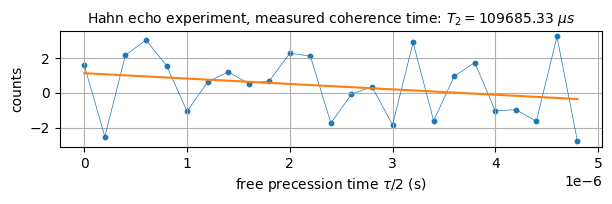

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

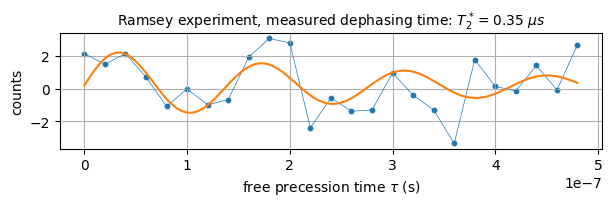

start measurements for orientation 4 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

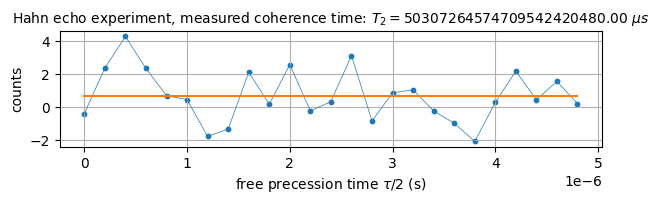

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

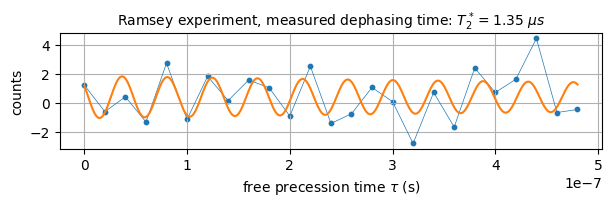

go to POI POI_13 ...
... position and counts at peak after refocus: (49.172, 44.170, 5.816) µm,  σ= (0.198, 0.165, 0.564) µm, peak cnts: 1.09E+05
start measurements for orientation 1 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

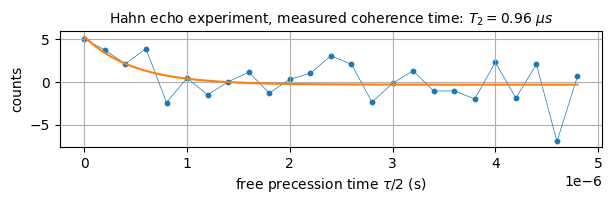

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

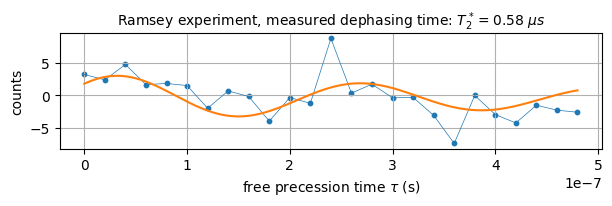

start measurements for orientation 2 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

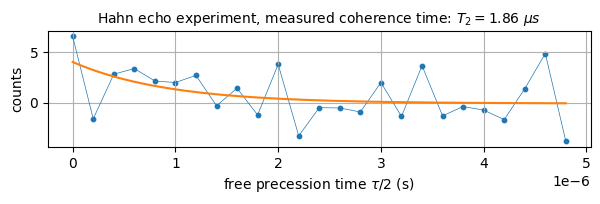

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

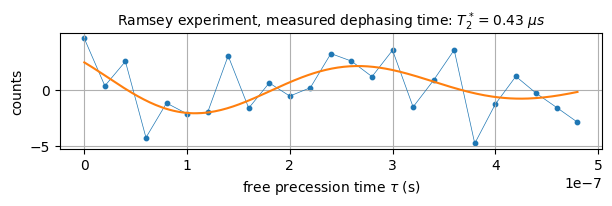

start measurements for orientation 3 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

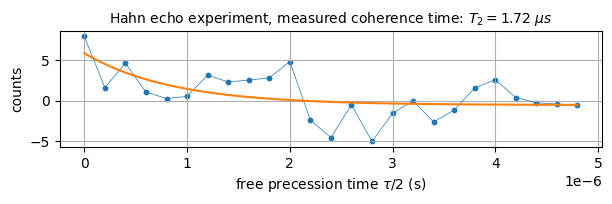

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

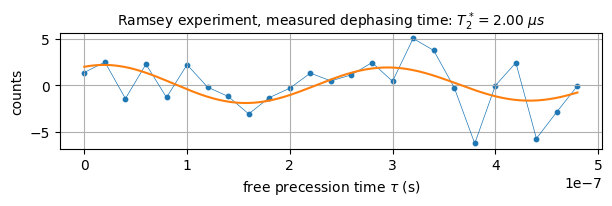

start measurements for orientation 4 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

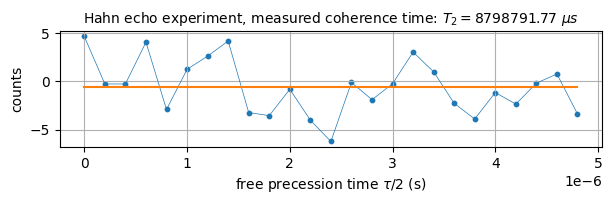

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

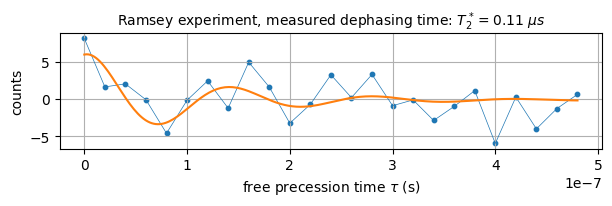

go to POI POI_14 ...
... position and counts at peak after refocus: (48.447, 47.205, 5.142) µm,  σ= (0.157, 0.175, 0.546) µm, peak cnts: 1.58E+05
start measurements for orientation 1 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

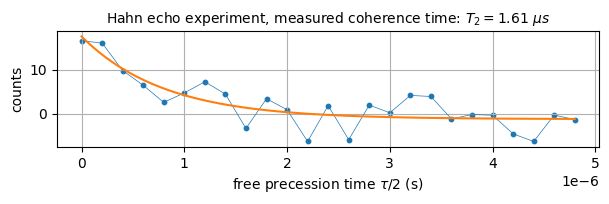

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

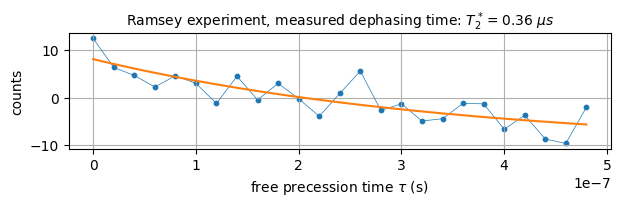

start measurements for orientation 2 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

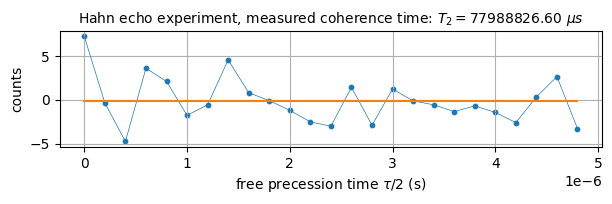

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

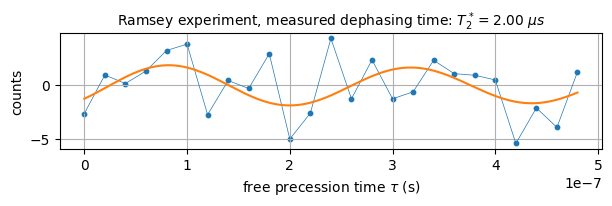

start measurements for orientation 3 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

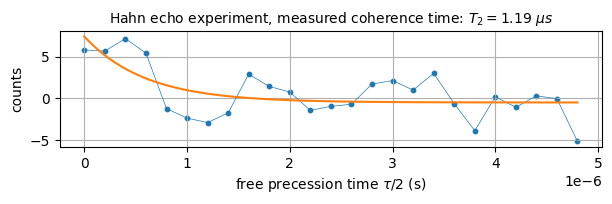

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

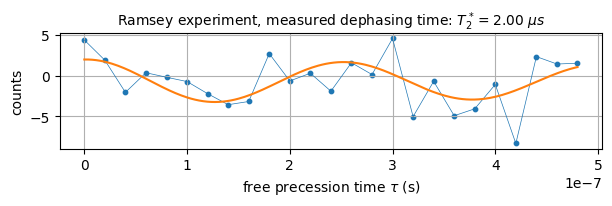

start measurements for orientation 4 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

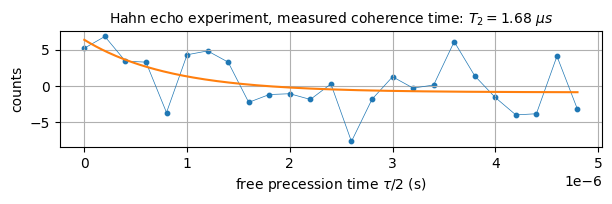

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

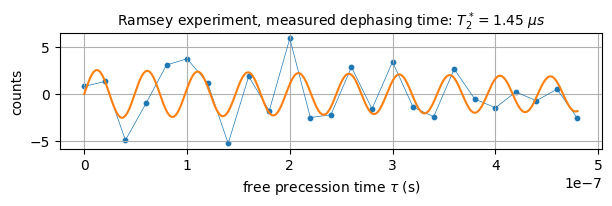

go to POI POI_1 ...
... position and counts at peak after refocus: (58.659, 46.454, 2.825) µm,  σ= (0.171, 0.141, 0.541) µm, peak cnts: 3.61E+04
start measurements for orientation 1 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

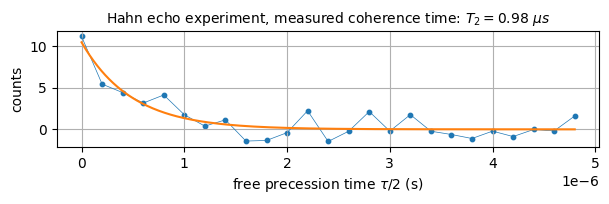

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

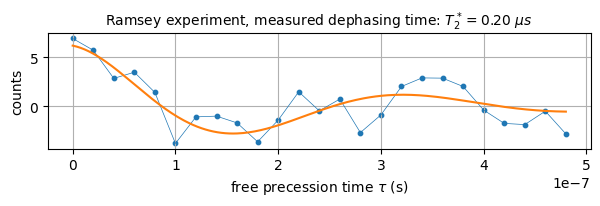

start measurements for orientation 2 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

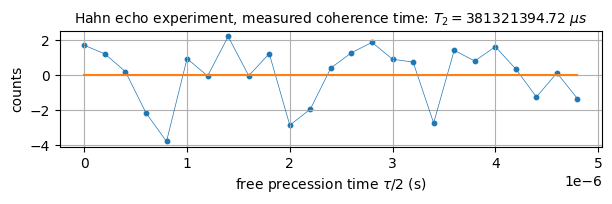

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

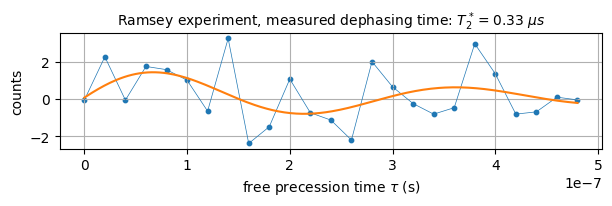

start measurements for orientation 3 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

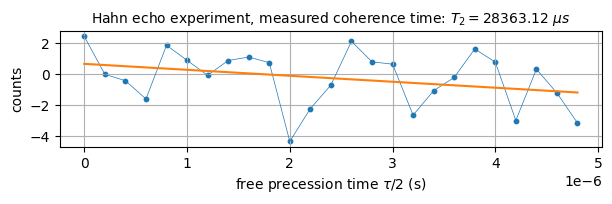

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

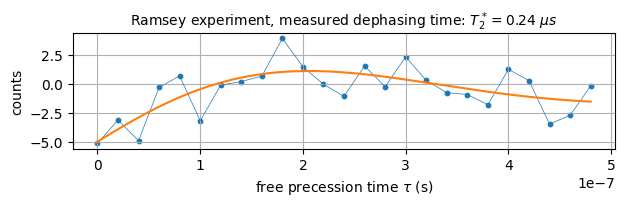

start measurements for orientation 4 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

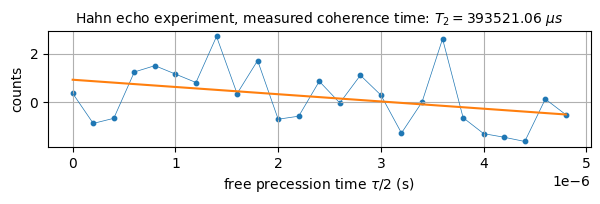

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

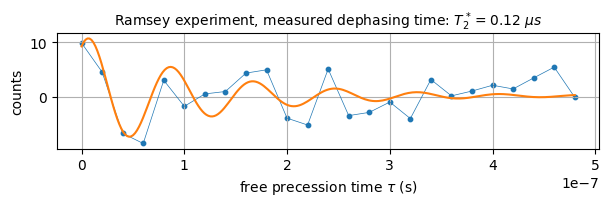

go to POI POI_2 ...
... position and counts at peak after refocus: (56.540, 49.447, -2.288) µm,  σ= (0.498, 0.445, 1.492) µm, peak cnts: 3.89E+06
start measurements for orientation 1 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

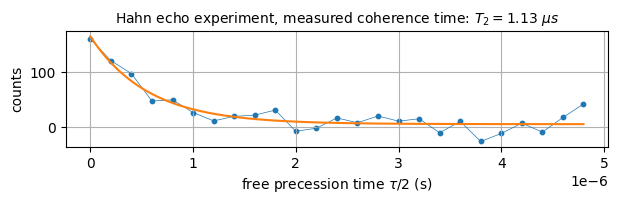

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

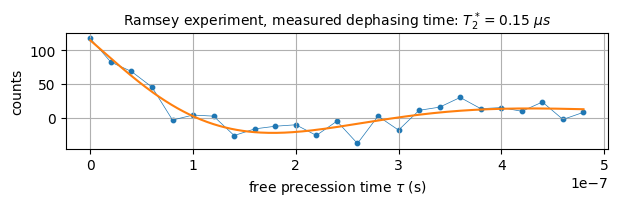

start measurements for orientation 2 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

 ... rabi:   0%|          | 0/500000.0 [00:00<?, ?sweeps/s]

 ... hahn_echo:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

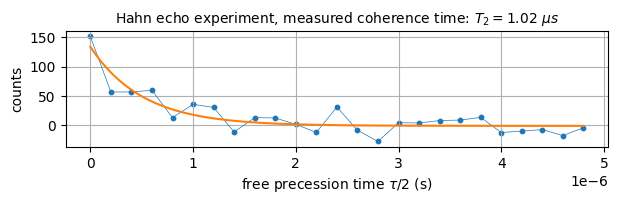

 ... ramsey:   0%|          | 0/700000.0 [00:00<?, ?sweeps/s]

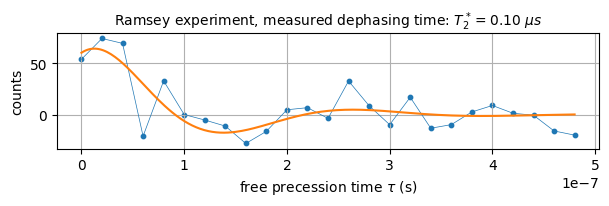

start measurements for orientation 3 ...


 ... pulsedODMR:   0%|          | 0/300000.0 [00:00<?, ?sweeps/s]

KeyboardInterrupt: 

In [47]:
outputFilename = f"characterization_run_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}.txt"
outputFile = open(outputFilename, 'w')

poi_list = [
    {'poi': 'POI_11', 'orientations': [1,2,3,4]},
    {'poi': 'POI_12', 'orientations': [1,2,3,4]},
    {'poi': 'POI_13', 'orientations': [1,2,3,4]},
    {'poi': 'POI_14', 'orientations': [1,2,3,4]},
    {'poi': 'POI_1',  'orientations': [1,2,3,4]},
    {'poi': 'POI_2',  'orientations': [1,2,3,4]},
    {'poi': 'POI_3',  'orientations': [1,2,3,4]},
    {'poi': 'POI_4',  'orientations': [1,2,3,4]},
    {'poi': 'POI_5',  'orientations': [1,2,3,4]},
    {'poi': 'POI_6',  'orientations': [1,2,3,4]},
    {'poi': 'POI_7',  'orientations': [1,2,3,4]},
    {'poi': 'POI_8',  'orientations': [1,2,3,4]},
    {'poi': 'POI_9',  'orientations': [1,2,3,4]},
    {'poi': 'POI_10', 'orientations': [1,2,3,4]},
]

freq_ranges = {
    1: [2645.0e6, 1.0e6, 50],
    2: [2750.0e6, 1.0e6, 50],
    3: [2795.0e6, 0.75e6, 50],
    4: [2855.0e6, 0.75e6, 50]
}
rabi_periods = {
    1: 150e-9,
    2: 160e-9,
    3: 165e-9,
    4: 170e-9
}

for entry in poi_list:
    currPoi = entry['poi']
    print(f'go to POI {currPoi} ...')
    # disable tracking before moving to the next POI
    poi_manager_logic.toggle_periodic_refocus(False)
    # wait until an ongoing optimization is terminated
    while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
        time.sleep(0.1)
    # move to next POI
    poi_manager_logic.go_to_poi(currPoi)
    poi_manager_logic.set_active_poi(currPoi)
    # enable tracking of POI
    poi_manager_logic.toggle_periodic_refocus(True)
    while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
        time.sleep(0.1)
    print( '... position and counts at peak after refocus: ' + scanner_gui.optimizer_dockwidget.result_label.text() )

    for orientation in entry['orientations']:
        print(f'start measurements for orientation {orientation} ...')
        freq_range = freq_ranges[orientation]

        while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
            time.sleep(0.1)
        countsStart = scanner_gui.optimizer_dockwidget.result_label.text()[-9:]
        
        # pulsed ODMR
        confocal2.pulsedODMR_params['freq_start'] = freq_range[0]
        confocal2.pulsedODMR_params['freq_step'] = freq_range[1]
        confocal2.pulsedODMR_params['num_of_points'] = freq_range[2]
        confocal2.generate_params['rabi_period'] = rabi_periods[orientation]
        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
        confocal2.pulsedODMR_sweeps = 3e5
        confocal2.do_pulsedODMR( f'{currPoi}_ornt_{orientation}')
        result_dict = netobtain( pulsed_measurement_logic.do_fit('Lorentzian Dip') )
        res_freq = result_dict.params['center'].value
        confocal2.calib_params['res_freq'] = res_freq

        # Rabi
        confocal2.rabi_sweeps = 5e5
        confocal2.do_rabi( f'{currPoi}_ornt_{orientation}', isSlow=True )
        result_dict = netobtain( pulsed_measurement_logic.do_fit('Sine') )
        rabi_period = 1 / result_dict.params['frequency'].value
        confocal2.generate_params['rabi_period'] = rabi_period
        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)

        # Hahn echo (T_2)
        confocal2.hahn_sweeps = 7e5
        confocal2.do_echo( f'{currPoi}_ornt_{orientation}' )
        result_dict = netobtain(pulsed_measurement_logic.do_fit('Exp Decay', use_alternative_data=True))
        t2 = 2*result_dict.params['decay'].value
        tData = netobtain(pulsed_measurement_logic.signal_data[0])
        sigData = netobtain(pulsed_measurement_logic.signal_data[1]) - netobtain(pulsed_measurement_logic.signal_data[2])
        plt.figure(figsize=(7, 1.5))
        plt.plot(tData, sigData, linewidth=0.5)
        plt.scatter(tData, sigData, s=10)
        plt.plot(result_dict.high_res_best_fit[0], result_dict.high_res_best_fit[1])
        plt.grid()
        plt.title(rf'Hahn echo experiment, measured coherence time: $T_2 =${t2 * 1e6:.2f} $\mu s$', fontsize=10)
        plt.ylabel('counts')
        plt.xlabel(r'free precession time $\tau/2$ (s)')
        plt.show()

        # Ramsey (T*_2)
        confocal2.ramsey_sweeps = 7e5
        confocal2.do_ramsey( f'{currPoi}_ornt_{orientation}' )
        result_dict = netobtain(pulsed_measurement_logic.do_fit('Exp. Decay Sine', use_alternative_data=True))
        t2star = result_dict.params['decay'].value
        tData = netobtain(pulsed_measurement_logic.signal_data[0])
        sigData = netobtain(pulsed_measurement_logic.signal_data[2]) - netobtain(pulsed_measurement_logic.signal_data[1])
        plt.figure(figsize=(7, 1.5))
        plt.plot(tData, sigData, linewidth=0.5)
        plt.scatter(tData, sigData, s=10)
        plt.plot( result_dict.high_res_best_fit[0], -result_dict.high_res_best_fit[1])
        plt.grid()
        plt.title(rf'Ramsey experiment, measured dephasing time: $T_2^* =${t2star * 1e6:.2f} $\mu s$', fontsize=10)
        plt.ylabel('counts')
        plt.xlabel(r'free precession time $\tau$ (s)')
        plt.show()

        while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
            time.sleep(0.1)
        countsEnd = scanner_gui.optimizer_dockwidget.result_label.text()[-9:]

        outputFile.write( f"{currPoi}\t{orientation}\t{countsStart}\t{countsEnd}\t{res_freq:.4E}\t{rabi_period:.2E}\t{t2:.2E}\t{t2star:.2E}\n" )
        outputFile.flush()

print('... all POIs in the list measured')
outputFile.close()